<a href="https://colab.research.google.com/github/r-doz/PML2025/blob/main/./08_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 8: Expectation Maximization (EM) algorithm

## The problem

Until now, we studied scenarios in which the model can be expressed as $p(\boldsymbol{X}| \boldsymbol{\theta})$, meaning that we can estimate the most likely parameters $\boldsymbol{\theta}_{ML}$ given the observed data $\boldsymbol{X}$. 

But what about the scenario in which we have *incomplete data* or only *partially-observable data*?
Consider the following example. We know that a candy box contains two kinds of items:
- sweet candies (type `A`), which weigh around 5 grams (with some variability);
- sour candies (type `B`), which weigh around 10 grams (also with some variability).

We don't know which candy is sweet or sour, we can only measure their weights (e.g. 4.9g, 10.1g, 5.3g, ...), but we don't know which type they belong to. 
This means that the probabilistic model will not simply be $p(\boldsymbol{X} | \boldsymbol{\theta})$, since the observed variable $\boldsymbol{X}$ (the weight) *will also depend on the latent variable* $\boldsymbol{Z}$ (the kind of candy we are considering). 

Consequently, the model will be: $p(\boldsymbol{X}, \boldsymbol{Z} | \boldsymbol{\theta})$, thus the task of finding: 
$$\boldsymbol{\theta}_{ML} = \argmax_{\boldsymbol{\theta}} p(\boldsymbol{X} | \boldsymbol{\theta})$$

is reasonably more complex. 

## First attempt of facing the problem

First thing first, to obtain $p(\boldsymbol{X}|\boldsymbol{\theta})$ we have to marginalize the joint distribution $p(\boldsymbol{X}, \boldsymbol{Z} | \boldsymbol{\theta})$ by summing over all possible combinations of latent variables' assignments $\boldsymbol{Z}$:
$$p(\boldsymbol{X} | \boldsymbol{\theta}) = \sum_{\boldsymbol{Z}} p(\boldsymbol{X}, \boldsymbol{Z} | \boldsymbol(\theta))$$

**this could intractable** if $\boldsymbol{Z}$ could assume a medium/large range of values (*this is obviously not the case of the candy example*, in which we have only 2 possibilies, but reality is extremely less simple to model!).


So, we have a solution for a small number of latent variable $\boldsymbol{Z}$ assignments? Of course no! Or, at least, not in general. 
Even when the summation is tractable, it could be **not numerically stable**. 

Typically we always worked with the log-likelihood $log \, p(\boldsymbol{X} | \boldsymbol{\theta})$ and this was due to the fact that, thanks to the logarithms properties, we are able to transform the product between (small) numbers to a sum ➔ this helps when we want to preserve numerical stability!
For example: 
$$ log \, p(\boldsymbol{X} | \boldsymbol{\theta}) = \sum_{i=1}^N log \, p(\boldsymbol{x_i} | \boldsymbol{\theta}) $$

Let's try to do the same thing in the presence of the latent variables: 
$$log \, p(\boldsymbol{X} | \boldsymbol{\theta}) =  log \Biggl( \sum_{i=1}^N p(\boldsymbol{x_i} | \boldsymbol{\theta}) \Biggr) = log \Biggl( \sum_{\boldsymbol{Z}} \prod_{i=1}^N p(\boldsymbol{x_i} | \boldsymbol{z_i}, \boldsymbol{\theta}) \cdot p(\boldsymbol{z_i} | \boldsymbol{\theta}) \Biggr) = log \Biggl(\prod_{i=1}^N \sum_{\boldsymbol{z_i}} p(\boldsymbol{x_i} | \boldsymbol{z_i}, \boldsymbol{\theta}) \cdot p(\boldsymbol{z_i} | \boldsymbol{\theta}) \Biggr) = \sum_{i=1}^N log \Biggl( \sum_{\boldsymbol{z_i}} p(\boldsymbol{x_i} | \boldsymbol{z_i}, \boldsymbol{\theta}) \cdot p(\boldsymbol{z_i} | \theta)\Biggr)$$
as you can see, it is not as easy as before and we are unable of disentangle the conditional dependencies present in the factorization of the joint distribution and get rid of the product.

## Second attempt of facing the problem: EM algorithm

The idea of the EM algorithm is to **alternate** the estimation of the distribution of latent variables $q(\boldsymbol{Z})$ keeping fixed the global parameters $\boldsymbol{\theta}$ (**Expectation step**), to the optimization of the global parameters keeping fixed the distribution of latent variables (**Maximization step**) until convergence is reached.

**EM algorithm:**
1. Initialize $\boldsymbol{\theta}$
2. Repeat until convergence:
    - E step: $q(\boldsymbol{Z}) \leftarrow p(\boldsymbol{Z} | \boldsymbol{X}, \boldsymbol{\theta})$
    - M step: $\boldsymbol{\theta} \leftarrow \argmax_{\boldsymbol{\theta}} \mathbb{E}_{q(\boldsymbol{Z})} p(\boldsymbol{X}, \boldsymbol{Z} | \boldsymbol{\theta})$

## Concrete example: EM for Gaussian Mixture Models

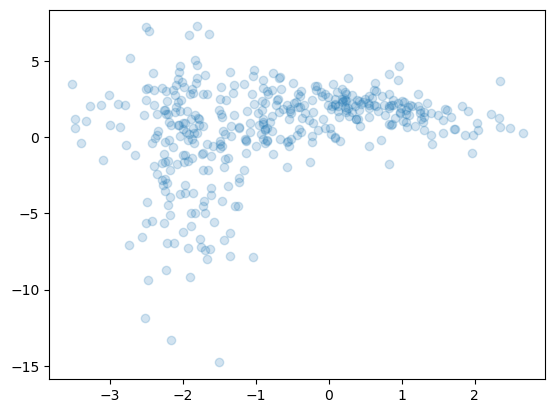

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

x = np.load('data/em.npy')
_ = plt.scatter(x[:, 0], x[:, 1], alpha=0.2)

you want to model them according to a mixture of 3 gaussians:

$$ p(\boldsymbol{x}_i, z_i | \boldsymbol{\theta}) = p(\boldsymbol{x}_i | z_i, \boldsymbol{\theta}) p(z_i | \boldsymbol{\theta}) \quad \text{where} \quad p(\boldsymbol{x}_i | z_i, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{x}_i; \mu_{z_i}, \Sigma_{z_i}) \quad \text{and} \quad P(z_i = k | \boldsymbol{\theta}) = \pi_{k}$$

where $z_i \in \{0, 1, 2\}$ and $\boldsymbol{\theta} = (\mu_{0}, \Sigma_{0}, \pi_0, \mu_{1}, \Sigma_{1}, \pi_1, \mu_{2}, \Sigma_{2}, \pi_2)$.


<img src="imgs/EM1.png" alt="drawing" width="200"/>

You want to find the set of parameters $\boldsymbol{\theta}$ that maximizes $p(\boldsymbol{x} | \boldsymbol{\theta})$, for example, since you are interested in the shapes and location of these three gaussians. Unfortunately this is intractable for numerical reasons.

### EM algorithm

Expectation Maximization is an algorithm that allows to find an **approximated solution** to this problem.

**EM algorithm:**
1. Initialize $\boldsymbol{\theta}$
2. Repeat until convergence:
    - E step: $q(\boldsymbol{Z}) \leftarrow p(\boldsymbol{Z} | \boldsymbol{X}, \boldsymbol{\theta})$
    - M step: $\boldsymbol{\theta} \leftarrow \argmax_{\boldsymbol{\theta}} \mathbb{E}_{q(\boldsymbol{Z})} p(\boldsymbol{X}, \boldsymbol{Z} | \boldsymbol{\theta})$

### Expectation step
We assume $p(\boldsymbol{Z} | \boldsymbol{X}, \boldsymbol{\theta})$ is easy to compute, in this case we have:
$$p(\boldsymbol{Z} | \boldsymbol{X}, \boldsymbol{\theta}) = \prod_i p(\boldsymbol{z}_i | \boldsymbol{x}_i, \boldsymbol{\theta})$$
where:
$$p(\boldsymbol{z}_i | \boldsymbol{x}_i, \boldsymbol{\theta}) \propto p(\boldsymbol{x}_i | \boldsymbol{z}_i, \boldsymbol{\theta})p(\boldsymbol{z}_i | \boldsymbol{\theta})$$
so the distribution for every $\boldsymbol{z}_i$ is:
$$q(\boldsymbol{z}_i) \propto p(\boldsymbol{x}_i | \boldsymbol{z}_i, \boldsymbol{\theta})p(\boldsymbol{z}_i | \boldsymbol{\theta})$$

### Maximization step
Having fixed $q(\boldsymbol{z}_i), \;\forall i$, we find $$\boldsymbol{\theta} = \argmax_{\boldsymbol{\theta}} \mathbb{E}_{q(\boldsymbol{Z})} \; p(\boldsymbol{X}, \boldsymbol{Z} | \boldsymbol{\theta})$$

Depending on the problem, this can be done analytically or by optimization.

### Gaussian mixture example

Let's go back to the previous example:

\begin{align*}
& p(\boldsymbol{x}_i | z_i, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{x}_i; \mu_{z_i}, \Sigma_{z_i}) \\
& P(z_i = k | \boldsymbol{\theta}) = \pi_{k}
\end{align*}

where $z_i \in \{0, 1, 2\}$ and $\boldsymbol{\theta} = (\mu_{0}, \Sigma_{0}, \pi_0, \mu_{1}, \Sigma_{1}, \pi_1, \mu_{2}, \Sigma_{2}, \pi_2)$.


**Expectation step:**

In [4]:
from typing import Tuple
import torch
from torch.distributions import MultivariateNormal

# Initialize theta = (pi, mean, cov), i.e. arbitrary model parameters values
theta_example = {'pi': torch.tensor([1/3, 1/3, 1/3]),
              
                'mean': torch.tensor([[0., 0.],
                                      [0., 0.],
                                      [0., 0.]]),
                
                'cov': torch.tensor([[[1., 0.],
                                      [0., 1.]],
                                     
                                     [[1., 0.],
                                      [0., 1.]],
                                        
                                      [[1., 0.],
                                       [0., 1.]]])}


# p(X|Z, theta)
def p_x_given_z_theta(x: torch.Tensor, z, theta: dict) -> torch.Tensor:
    return MultivariateNormal(
        loc  = theta['mean'][z],
        covariance_matrix = theta['cov'][z]).log_prob(x).exp()
    

# p(Z|theta)
def p_z_given_theta(z:  torch.Tensor, theta: dict)-> torch.Tensor:
    return theta['pi'][z]


# p(Z|X, theta)
def p_z_given_x_theta(x:  torch.Tensor, theta: dict) -> torch.Tensor:
    q_z = torch.stack([p_x_given_z_theta(x, j, theta)*p_z_given_theta(j, theta) for j in range(len(theta["pi"]))], dim = 1)
    q_z = q_z / q_z.sum(dim=1, keepdim=True) # normalize
    return q_z

**Maximization Step:**

For the Gaussian Mixture case, the maximization step can be done analytically. It consists in computing weighted means and covariances:

\begin{gather*}
    \mu_j^{new} = \frac{1}{N_j} \sum_n q(z_{n}=j)x_n \\
    \Sigma_j^{new} = \frac{1}{N_j} \sum_n q(z_{n}=j) (x_n - \mu_j^{new})^T(x_n - \mu_j^{new}) \\
    \pi_j^{new} = \frac{N_j}{N}, \qquad N_j = \sum_{n=1}^N q(z_{n} = j)
\end{gather*}

In [5]:
# This function returns the weighted mean and covariance of x, given weights w
def weighted_mean_cov(x: torch.Tensor, w: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    w = w.unsqueeze(1) / w.sum()
    mean = (x*w).sum(0)
    centered_x = x - mean
    cov = (centered_x.unsqueeze(1) * centered_x.unsqueeze(2) * w.reshape(-1,1,1)).sum(0)
    return mean, cov


def update_theta(x: torch.Tensor, q_z: torch.Tensor) -> dict:
    # init
    means = torch.zeros(q_z.shape[1], x.shape[1])
    covs = torch.zeros(q_z.shape[1], x.shape[1], x.shape[1])

    for j in range(q_z.shape[1]):
        means[j], covs[j] = weighted_mean_cov(x, q_z[:,j])

    pi = q_z.mean(dim=0) 

    return {'pi': pi, 'mean': means, 'cov': covs}

**EM algorithm**

In [7]:
from tqdm.notebook import tqdm

def EM(x, *, theta_init: dict, max_iter: int = 100):
    # x_tensor = torch.tensor(x, dtype=torch.float32)
    theta = theta_init
    for _ in tqdm(range(max_iter)):
        q_z = p_z_given_x_theta(x, theta)
        theta = update_theta(x, q_z)
    return theta, p_z_given_x_theta(x, theta)

Now use EM to find $\theta$ and $p(Z | \boldsymbol{X}, \theta)$

In [9]:
theta_init = {'pi': torch.tensor([1/3, 1/3, 1/3]),
              
                'mean': torch.tensor([[-1.0, -1.0], 
                                      [0.0, 0.0], 
                                      [1.0, 1.0]]), 
                
                'cov': torch.tensor([[[1., 0.],
                                      [0., 1.]],
                                     
                                     [[1., 0.],
                                      [0., 1.]],
                                        
                                      [[1., 0.],
                                       [0., 1.]]])*100}

theta, q_z = EM(torch.tensor(x), theta_init = theta_init, max_iter=100)

print(theta)

  0%|          | 0/100 [00:00<?, ?it/s]

{'pi': tensor([0.3013, 0.4424, 0.2564]), 'mean': tensor([[-1.9535, -1.7773],
        [-0.8660,  1.2497],
        [ 0.6628,  1.9906]]), 'cov': tensor([[[ 0.1488, -0.1952],
         [-0.1952, 19.0142]],

        [[ 1.4381,  0.0822],
         [ 0.0822,  2.1052]],

        [[ 0.6781, -0.5485],
         [-0.5485,  0.7672]]])}


Let's plot every point with $p(z_i | \boldsymbol{x}_i, \theta)$

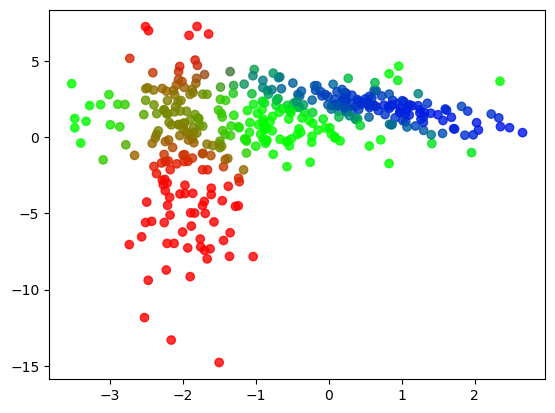

In [10]:
_ = plt.scatter(x[:, 0], x[:, 1], c= q_z.numpy(), alpha=0.8)

In [11]:
# q_z[i] = [0.1, 0.8, 0.1] - green, almost
# [1, 0, 1] - red

Let's compare it with K-means

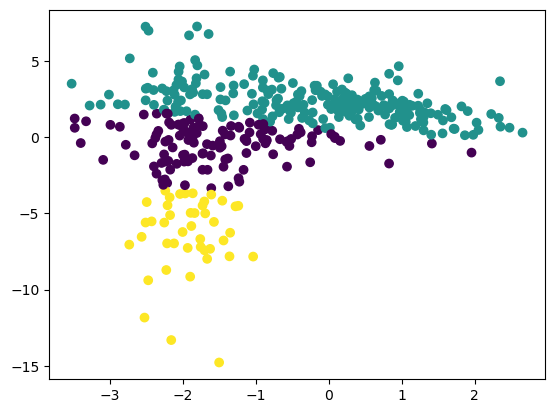

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto', random_state=0)
kmeans.fit(x)
_ = plt.scatter(x[:, 0], x[:, 1], c=kmeans.labels_, cmap='viridis')

It is common to use the result of k-means to initialize the parameters for EM:

  0%|          | 0/100 [00:00<?, ?it/s]

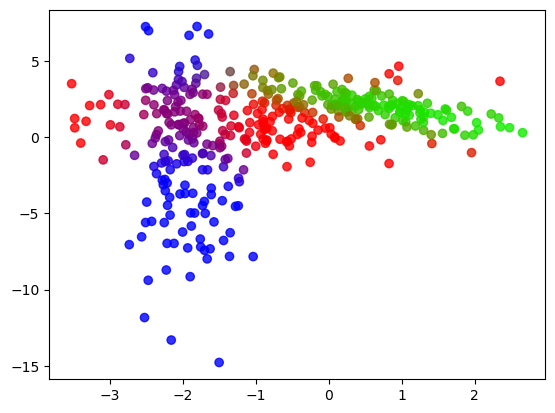

In [14]:
z = kmeans.labels_

pi = np.bincount(z) / len(z)

means = np.array([x[z==j].mean(0) for j in range(3)])
covs = np.array([np.cov(x[z==j].T) for j in range(3)])

theta_init_k_means = {
                      'pi': torch.tensor(pi),
                      'mean': torch.tensor(means),
                      'cov': torch.tensor(covs)
                     }

theta, q_z = EM(torch.tensor(x), theta_init=theta_init_k_means)
_ = plt.scatter(x[:, 0], x[:, 1], c= q_z.numpy(), alpha=0.8)